# drlnd Project 2: Continuous Control, Second Version (20 agents)



https://github.com/sliao-mi-luku/DeepRL-continuous-control-reachers-udacity-drlnd-p2


Reinforcement learning environment by Unity ML-Agents

This corresponds to Project #2 of Udacity's Deep Reinforcement Learning Nanodegree (drlnd)\
https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

The deep deterministeic policy gradients (DDPG) method is implemented for this project

**Reference**: this code was inspired by:

1. Udacity's Github repository **ddpg-pendulum**\
   https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum


2. Udacity's project workspace (jupyter notebook)

## Box 1: Starting the environment

Run the box below to import necessary packages.

In the command `env = UnityEnvironment(file_name = '...')` paste the path to `Reacher.exe`

For example: `env = UnityEnvironment(file_name = './Reacher_20Agent_Windows_x86_64/Reacher.exe')`


In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, namedtuple
from unityagents import UnityEnvironment
from networkModels import ActorNetwork, CriticNetwork
from ddpgAgent import DDPG_Agent
from buffer import Buffer
from noiseModels import OUNoise, plot_OU
from ddpg_singleAgentMode import DDPG

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice: {}".format(device))


"""
Starting the second version of the project (with 20 agents)
"""
# file_name = /the/path/to/Reacher.exe
env = UnityEnvironment(file_name = './Reacher_20Agent_Windows_x86_64/Reacher.exe')


"""
Environments contain brains which are responsible for deciding the actions of their associated agents
"""
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


"""
The codes below were provided by Udacity, which will display some information of the environment
"""
# reset the environment (train_mode is set to False because we're not training)
env_info = env.reset(train_mode=False)[brain_name]
# number of agents (should be 20)
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action (should be 4)
action_size = brain.vector_action_space_size
print('\nSize of each action:', action_size)
# examine the state space (should be 33)
states = env_info.vector_observations
state_size = states.shape[1]
print('\nThere are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('\nThe state for the first agent looks like:', states[0])


print("\nBox 1 done!")


Device: cuda:0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20

Size of each action: 4

There are 20 agents. Each observes a state with length: 33

The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]

Box 1 done!


## Box 2: Setting parameters

In [2]:
num_agents = 20

EPISODES = 1000

PRINT_EVERY = 10

# Actor and Critic networks
actor_input_size = 33
actor_output_size = 4
actor_hidden_sizes = [400, 300]

critic_state_size = 33
critic_action_size = 4
critic_hidden_sizes = [400, 300]

# optimizers
actor_lr = 1e-3
critic_lr = 1e-4
critic_L2_decay = 0.0

# discounting
gamma = 0.99

# soft-updating
tau = 1e-3

# Ornstein–Uhlenbeck process
ou_scale = 1.0
ou_decay = 0.995
ou_mu = 0.0
ou_theta = 0.15
ou_sigma = 0.10

# buffer
buffer_size = int(1e6)
batch_size = 512

# seed
seed = 0
random.seed(seed)
np.random.seed(seed)


print("\n Box 2 done!")


 Box 2 done!


## Box 3: Deep Deterministic Policy Gradients (DDPG)

actor_hidden_sizes = [400, 300]
actor_lr = 0.001
critic_hidden_sizes = [400, 300]
critic_lr = 0.0001
critic_L2_decay = 0.0
gamma = 0.99
tau = 0.001
ou_scale = 1.0
ou_decay = 0.995
ou_mu = 0.0
ou_theta = 0.15
ou_sigma = 0.1
buffer_size = 1000000
batch_size = 512



Noise Process:


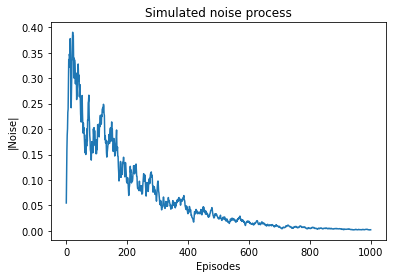



Episode 10	Score: 2.06	Avg: 0.99	A_loss: -0.109153	C_loss: 0.000028	ou: 0.344
Episode 20	Score: 19.04	Avg: 5.85	A_loss: -0.217519	C_loss: 0.000123	ou: 0.291
Episode 30	Score: 36.46	Avg: 14.36	A_loss: -0.545315	C_loss: 0.000356	ou: 0.250
Episode 40	Score: 39.42	Avg: 20.60	A_loss: -0.951530	C_loss: 0.000681	ou: 0.196
Episode 50	Score: 39.51	Avg: 24.38	A_loss: -1.348591	C_loss: 0.002645	ou: 0.184
Episode 60	Score: 39.46	Avg: 26.90	A_loss: -1.766029	C_loss: 0.000223	ou: 0.158
Episode 70	Score: 39.38	Avg: 28.70	A_loss: -2.095511	C_loss: 0.003417	ou: 0.137
Episode 80	Score: 39.18	Avg: 30.01	A_loss: -2.335487	C_loss: 0.000065	ou: 0.123
Episode 90	Score: 39.02	Avg: 31.02	A_loss: -2.513193	C_loss: 0.003771	ou: 0.104
Episode 100	Score: 38.41	Avg: 31.82	A_loss: -2.688791	C_loss: 0.000071	ou: 0.103


Environment is solved after 0 episodes


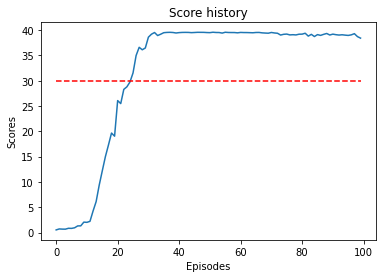

In [3]:
# set ou_scale = 1.0 again in case this box is executed more than once
ou_scale = 1.0


## print parameters
print("actor_hidden_sizes = {}".format(actor_hidden_sizes))
print("actor_lr = {}".format(actor_lr))
print("critic_hidden_sizes = {}".format(critic_hidden_sizes))
print("critic_lr = {}".format(critic_lr))
print("critic_L2_decay = {}".format(critic_L2_decay))
print("gamma = {}".format(gamma))
print("tau = {}".format(tau))
print("ou_scale = {}".format(ou_scale))
print("ou_decay = {}".format(ou_decay))
print("ou_mu = {}".format(ou_mu))
print("ou_theta = {}".format(ou_theta))
print("ou_sigma = {}".format(ou_sigma))
print("buffer_size = {}".format(buffer_size))
print("batch_size = {}\n".format(batch_size))
print("\n")


## DDPG
avg_score_deque = deque(maxlen = 100)
avg_score_list = []

AL_list = []
CL_list = []

buffer = Buffer(buffer_size, batch_size, seed)

agents = DDPG(actor_input_size, actor_output_size, actor_hidden_sizes,
                critic_state_size, critic_action_size, critic_hidden_sizes, seed,
                actor_lr, critic_lr, critic_L2_decay, 
                gamma, tau)

noise_process = OUNoise(int(num_agents*4), ou_mu, ou_theta, ou_sigma, seed)

print("Noise Process:")
plot_OU(EPISODES, ou_scale, ou_decay, 1, ou_mu, ou_theta, ou_sigma, seed)
print("\n")

for ep in range(1, EPISODES+1):
    
    env_info = env.reset(train_mode = True)[brain_name]
    states = env_info.vector_observations # [1, 33]
    scores = 0
    
    t_step = 0
    
    noise_process.reset()
    
    while True:
        
        t_step += 1

        states_tensor = torch.from_numpy(states).float().to(device)
        
        # generate noise
        noise = noise_process.get_noise().reshape((num_agents, 4)) # [num_agents, 4]
        noise *= ou_scale
        noise = np.multiply(noise, np.random.choice([1, -1], size = (num_agents, 4)))
            
        # take actions (with noise, without back propagation)
        actions = agents.get_action_by_actor_local(states_tensor, noise) # [num_agents, 4]
            
        noise_display = np.round(np.max(noise), 3)

        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        # add into buffer
        for agent_i in range(num_agents):
            buffer.add(states[agent_i], actions[agent_i], rewards[agent_i], next_states[agent_i], dones[agent_i])
        
        scores += np.mean(np.array(rewards))
        states = next_states
        
        # update
        if len(buffer) >= batch_size:
            replays = buffer.sample()
            agents.update(0, replays)
                            
        if np.any(dones):
            break
    
    # log individual scores
    avg_score_list.append(scores)
    avg_score_deque.append(scores)
        
    S = scores
    AVGS = np.mean(avg_score_deque)
    AL = np.round(agents.current_actor_loss, 6)
    CL = np.round(agents.current_critic_loss, 6)
    
    AL_list.append(AL)
    CL_list.append(CL)
    
    print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tA_loss: {:.6f}\tC_loss: {:.6f}\tou: {:.3f}".format(
        ep, S, AVGS, AL, CL, noise_display), end="")
    
    if ep % PRINT_EVERY == 0:
        print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tA_loss: {:.6f}\tC_loss: {:.6f}\tou: {:.3f}".format(
            ep, S, AVGS, AL, CL, noise_display))
    
    if AVGS > 30 and len(avg_score_deque) >= 100:
        print("\n\nEnvironment is solved after {} episodes".format(ep-100))
        break
        
    ou_scale *= ou_decay
    

## Save the weights
torch.save(agents.players[0].actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agents.players[0].critic_local.state_dict(), 'checkpoint_critic.pth')

plt.figure()
plt.plot(range(len(avg_score_list)), avg_score_list)
plt.plot([0, len(avg_score_list)-1], [30.0, 30.0], 'r--')
plt.title("Score history")
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.show()


## Box 4: Loading trained weights

In [4]:
## Test the saved weights

agents = DDPG(actor_input_size, actor_output_size, actor_hidden_sizes,
                critic_state_size, critic_action_size, critic_hidden_sizes, seed,
                actor_lr, critic_lr, critic_L2_decay, 
                gamma, tau)

actor_weights = torch.load('checkpoint_actor.pth')
critic_weights = torch.load('checkpoint_critic.pth')

agents.players[0].actor_local.load_state_dict(actor_weights)
agents.players[0].critic_local.load_state_dict(critic_weights)

env_info = env.reset(train_mode = False)[brain_name] 
states = env_info.vector_observations
scores = 0

while True:
    states_tensor = torch.from_numpy(states).float().to(device)
    actions = agents.players[0].actor_local(states_tensor).cpu().detach().numpy()
    env_info = env.step(actions)[brain_name] 
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done 
    scores += sum(rewards)/20.0
    states = next_states
    if np.any(dones):
        break
        
print('Total score (averaged over agents) this episode: {:.2f}'.format(scores))


Total score (averaged over agents) this episode: 39.45


In [5]:
env.close()